In [ ]:
from google.colab.patches import cv2_imshow as imshow
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#!mkdir /content/images/
#!unzip /content/drive/MyDrive/Colab\ Notebooks/hard.zip -d /content/images/
#!mkdir /content/images/hard/train
#!unzip /content/images/hard/train.zip -d /content/images/hard/train
#!mkdir /content/images/hard/test
#!unzip /content/images/hard/test.zip -d /content/images/hard/test

In [ ]:
import pandas as pd
from google.colab import data_table
data_table.enable_dataframe_formatter()

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 5)
pd.set_option('display.width', 1000)

df = pd.DataFrame({'name':[], 'img' : [], 'label': [], 'xmin': [], 'ymin': [], 'xmax': [], 'ymax': []})
df

,name,img,...,xmax,ymax


# Process XML Data

In [ ]:
import os
import xml.etree.ElementTree as ET
basedir = r'/content/images/hard/test/'

for file in os.listdir(basedir):
  filename = os.path.join(basedir, file)
  filenoend = file.split(".")[0]
  fileend = file.split(".")[1]

  if fileend=="xml": # Add Image to Dataframe
    root = ET.parse(filename).getroot()
    for child in root:
      if child.tag == "object":
        label = child.find("name").text

        bndbox = child.find("bndbox")
        xmin = bndbox.find("xmin").text
        ymin = bndbox.find("ymin").text
        xmax = bndbox.find("xmax").text
        ymax = bndbox.find("ymax").text

        data = [filenoend, label, xmin, ymin, xmax, ymax]
        new_row = pd.DataFrame([data], columns=['name','label','xmin','ymin','xmax','ymax'], index=[filenoend])
        df = df.append(new_row)   
  elif fileend=="jpg":
    images = cv2.imread(filename)

In [ ]:
df["img"]=df.apply(
    lambda row: cv2.imread(basedir+row.name+".jpg"), axis=1
)

In [ ]:
df["cropped"]=df.apply(
    lambda row: row.img[int(row.ymin):int(row.ymax),int(row.xmin):int(row.xmax)], axis=1
)

In [ ]:
df

,name,img,...,ymax,cropped
IMG_20211122_212235,IMG_20211122_212235,"[[[43, 30, 38], [43, 30, 38], [41, 30, 38], [4...",...,87,"[[[61, 57, 68], [51, 53, 63], [50, 54, 65], [5..."
IMG_20211122_212235,IMG_20211122_212235,"[[[43, 30, 38], [43, 30, 38], [41, 30, 38], [4...",...,88,"[[[48, 49, 59], [42, 47, 62], [38, 45, 64], [3..."
IMG_20211122_212235,IMG_20211122_212235,"[[[43, 30, 38], [43, 30, 38], [41, 30, 38], [4...",...,118,"[[[45, 45, 57], [47, 49, 60], [42, 45, 59], [3..."
IMG_20211122_212235,IMG_20211122_212235,"[[[43, 30, 38], [43, 30, 38], [41, 30, 38], [4...",...,126,"[[[48, 46, 58], [48, 44, 56], [46, 42, 54], [4..."
IMG_20211122_212235,IMG_20211122_212235,"[[[43, 30, 38], [43, 30, 38], [41, 30, 38], [4...",...,148,"[[[28, 15, 23], [26, 12, 23], [27, 16, 26], [2..."
...,...,...,...,...,...
IMG_20211115_222141,IMG_20211115_222141,"[[[169, 172, 180], [168, 171, 179], [168, 171,...",...,144,"[[[139, 146, 155], [141, 148, 157], [138, 147,..."
IMG_20211115_222141,IMG_20211115_222141,"[[[169, 172, 180], [168, 171, 179], [168, 171,...",...,126,"[[[140, 143, 148], [142, 145, 149], [140, 145,..."
IMG_20211115_222141,IMG_20211115_222141,"[[[169, 172, 180], [168, 171, 179], [168, 171,...",...,95,"[[[163, 166, 171], [165, 168, 172], [165, 170,..."
IMG_20211115_222141,IMG_20211115_222141,"[[[169, 172, 180], [168, 171, 179], [168, 171,...",...,52,"[[[179, 183, 188], [171, 174, 182], [172, 174,..."


In [ ]:
#df.loc["IMG_20211121_215921"]
df.to_pickle("hard-test-cropped.pkl")

# Read DF

In [ ]:
df = pd.read_pickle("/content/hard-train-cropped.pkl")

In [ ]:
#df.loc["IMG_20211121_215921"]

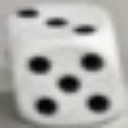

3
2


In [ ]:
imshow(cv2.resize(df.iloc[0].cropped, (128,128)))
print(df.iloc[0].label)
#print(df.iloc[0].name)

# Model and Training

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding="same"))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (7, 7), activation='relu', padding="same"))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(7, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 dropout_4 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       200832    
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                      

In [ ]:
"""
x_train = train.values[:,0]
y_train = train.values[:,1]

xaug = []
yaug = []

for idx, img in enumerate(x_train):
  xaug.append(np.fastCopyAndTranspose(img))
  yaug.append(y_train[idx])

  #xaug.append(np.flip(np.fastCopyAndTranspose(img)))
  #yaug.append(y_train[idx])

  xaug.append(np.flip(np.fastCopyAndTranspose(img),0))
  yaug.append(y_train[idx])

  #xaug.append(np.flip(np.fastCopyAndTranspose(img),1))
  #yaug.append(y_train[idx])

  xaug.append(np.flip(img))
  yaug.append(y_train[idx])

  #xaug.append(np.flip(img,0))
  #yaug.append(y_train[idx])

  #xaug.append(np.flip(img,1))
  #yaug.append(y_train[idx])

xaug = np.stack(xaug)
x_train = np.stack(x_train)
x_train = np.append(xaug, x_train, axis=0)

yaug = np.stack(yaug)
y_train = np.stack(y_train)
y_train = np.append(yaug, y_train, axis=0)


for augs in range(7):
  np.append(y_train, y_train)




x_test = test.values[:,0]
x_test = np.stack(x_test)

y_test = test.values[:,1]
y_test = np.stack(y_test)

print(x_train.shape)
print(y_train.shape)
"""

'\nx_train = train.values[:,0]\ny_train = train.values[:,1]\n\nxaug = []\nyaug = []\n\nfor idx, img in enumerate(x_train):\n  xaug.append(np.fastCopyAndTranspose(img))\n  yaug.append(y_train[idx])\n\n  #xaug.append(np.flip(np.fastCopyAndTranspose(img)))\n  #yaug.append(y_train[idx])\n\n  xaug.append(np.flip(np.fastCopyAndTranspose(img),0))\n  yaug.append(y_train[idx])\n\n  #xaug.append(np.flip(np.fastCopyAndTranspose(img),1))\n  #yaug.append(y_train[idx])\n\n  xaug.append(np.flip(img))\n  yaug.append(y_train[idx])\n\n  #xaug.append(np.flip(img,0))\n  #yaug.append(y_train[idx])\n\n  #xaug.append(np.flip(img,1))\n  #yaug.append(y_train[idx])\n\nxaug = np.stack(xaug)\nx_train = np.stack(x_train)\nx_train = np.append(xaug, x_train, axis=0)\n\nyaug = np.stack(yaug)\ny_train = np.stack(y_train)\ny_train = np.append(yaug, y_train, axis=0)\n\n\nfor augs in range(7):\n  np.append(y_train, y_train)\n\n\n\n\nx_test = test.values[:,0]\nx_test = np.stack(x_test)\n\ny_test = test.values[:,1]\ny_test

In [ ]:
train_df = pd.read_pickle("/content/hard-train-cropped.pkl")
test_df = pd.read_pickle("/content/hard-test-cropped.pkl")

def process_dataframe(df):
  inputs = []
  labels = []
  for idx, row in df.iterrows():
    x = row.cropped
    equisized = cv2.resize(x, (28,28)) # All images have to be the Same size to be fed throught the CNN
    monochromed = cv2.cvtColor(equisized, cv2.COLOR_BGR2GRAY) # Color doesnt matter for dices
    normalized = monochromed / 255.0 # Normalize pixel values to be between 0 and 1
    inputs.append(normalized)
    labels.append(row.label)
  return np.array(inputs), np.array([int(x) for x in labels])


inputs, labels = process_dataframe(train_df)
print(inputs.shape)
test_in, test_lab = process_dataframe(test_df)

(651, 28, 28)


3


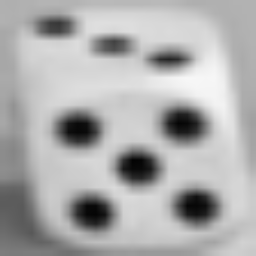

3


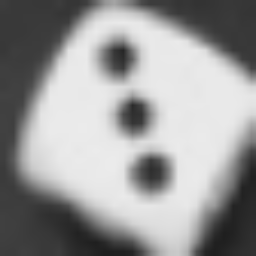

In [ ]:
print(labels[0])
imshow(cv2.resize(inputs[0]*255,(256,256)))
print(test_lab[0])
imshow(cv2.resize(test_in[0]*255,(256,256)))

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(labels.shape)
print(inputs.shape)
history = model.fit(inputs, labels, epochs=50, batch_size=16, validation_data=(test_in, test_lab))
#history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

(651,)
(651, 28, 28)
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


41/41 [==============================] - 6s 122ms/step - loss: 1.8367 - accuracy: 0.1674 - val_loss: 1.7969 - val_accuracy: 0.2125
Epoch 2/50
41/41 [==============================] - 4s 101ms/step - loss: 1.7882 - accuracy: 0.2074 - val_loss: 1.7821 - val_accuracy: 0.2313
Epoch 3/50
41/41 [==============================] - 4s 101ms/step - loss: 1.7353 - accuracy: 0.2519 - val_loss: 1.7081 - val_accuracy: 0.2937
Epoch 4/50
41/41 [==============================] - 4s 101ms/step - loss: 1.6294 - accuracy: 0.3210 - val_loss: 1.6818 - val_accuracy: 0.2750
Epoch 5/50
41/41 [==============================] - 4s 102ms/step - loss: 1.4833 - accuracy: 0.4163 - val_loss: 1.5773 - val_accuracy: 0.3750
Epoch 6/50
41/41 [==============================] - 4s 101ms/step - loss: 1.4185 - accuracy: 0.4485 - val_loss: 1.5620 - val_accuracy: 0.3938
Epoch 7/50
41/41 [==============================] - 4s 101ms/step - loss: 1.3035 - accuracy: 0.4962 - val_loss: 1.4138 - val_accuracy: 0.4875
Epoch 8/50
41/41 

In [ ]:
#model.save("/content/small_cnn_50_epoch_hard")
!zip -r /content/small_cnn_50_epoch_hard.zip /content/small_cnn_50_epoch_hard/

  adding: content/small_cnn_50_epoch_hard/ (stored 0%)
  adding: content/small_cnn_50_epoch_hard/assets/ (stored 0%)
  adding: content/small_cnn_50_epoch_hard/keras_metadata.pb (deflated 89%)
  adding: content/small_cnn_50_epoch_hard/saved_model.pb (deflated 88%)
  adding: content/small_cnn_50_epoch_hard/variables/ (stored 0%)
  adding: content/small_cnn_50_epoch_hard/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: content/small_cnn_50_epoch_hard/variables/variables.index (deflated 62%)


# Evaluation

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 - 0s - loss: 2.3861 - accuracy: 0.6750 - 326ms/epoch - 65ms/step


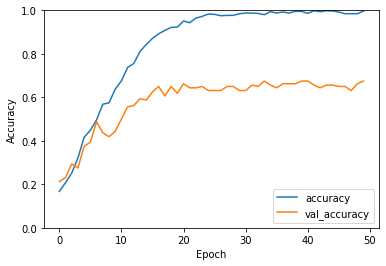

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_in,  test_lab, verbose=2)

5/5 - 0s - loss: 2.3861 - accuracy: 0.6750 - 298ms/epoch - 60ms/step


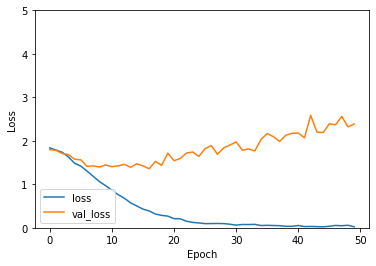

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='lower left')

test_loss, test_acc = model.evaluate(test_in,  test_lab, verbose=2)

In [ ]:
predictions = []
for i, j in enumerate(test_in):
  y = model.predict(test_in[i].reshape(1,28,28,-1))
  predictions.append(y)
  if(not np.argmax(y)==test_lab[i]):
    imshow(test_in[i]*255)
    print(np.argmax(y))
    #print(np.argmax(y))
    #print(i)

confusion = np.zeros((7, 7))
for idx, i in enumerate(test_lab):
  pred_label = np.argmax(predictions[idx])
  confusion[test_lab[idx]][pred_label]+=1

print(confusion)

4


6


4


5


1


1


6


6


4


6


2


6


6


3


6


2


6


3


5


2


6


3


6


3


5


5


6


2


3


4


3


6


6


3


6


2


6


5


6


6


6


6


6


2


6


5


6


6


6


6


6


6
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. 12.  1.  2.  0.  0.  2.]
 [ 0.  2. 16.  4.  0.  1.  0.]
 [ 0.  0.  4. 21.  1.  2.  7.]
 [ 0.  0.  1.  0. 20.  2. 11.]
 [ 0.  0.  0.  1.  1. 13.  7.]
 [ 0.  0.  0.  0.  2.  1. 26.]]


conv2d_4 (3, 3, 1, 32)
conv2d_5 (7, 7, 32, 128)


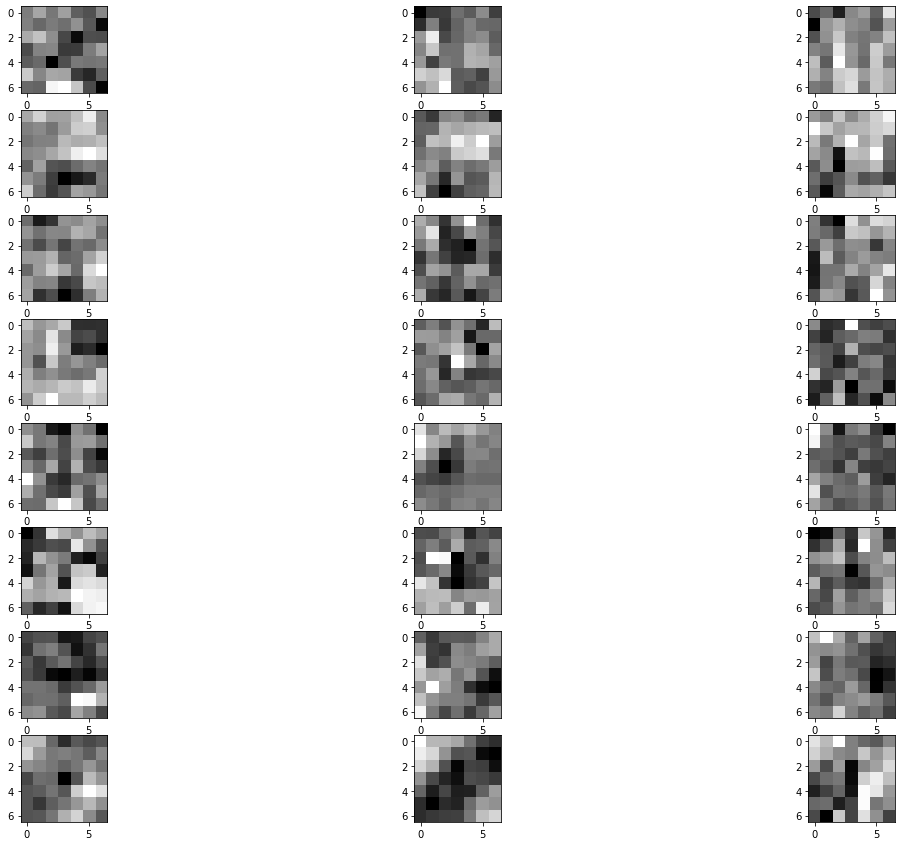

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

for layer in model.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

n_filters = 8
ix=1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
plt.show()